# <center>Analiza wystąpień posłów Sejmu RP IX kadencji</center>

## <center>Karol Kołodziej, Jakub Gotlib</center>

In [4]:
# !pip install selenium
# !pip install bertopic
# !pip install webdriver-manager
# !pip list
# !pip install sentimentpl
# !pip install sacremoses
# driver = webdriver.Chrome(ChromeDriverManager().install())

import requests
import json
import re
# import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from datetime import datetime
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep
from webdriver_manager.chrome import ChromeDriverManager

from bertopic import BERTopic
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from sentimentpl.models import SentimentPLModel

# spacy.cli.download("pl_core_news_md")

## Tworzenie zbioru danych

W pierwszej kolejności przygotujmy scraper, który pobierze dane o wszystkich wystąpieniach posłów. W szczególności w biorze danych znajdą się następujące informacje:

*  imię i nazwisko osoby przemawiającej,
*  data wystąpienia,
*  treść wystąpienia,
*  numer posiedzenia sejmu,
*  w którym dniu posiedzienia miało miejsce wystąpienie.

In [2]:
def Get_single_speech (url):
    # page - przykładowa strona
    # page = requests.get("https://www.sejm.gov.pl/sejm9.nsf/wypowiedz.xsp?posiedzenie=75&dzien=1&wyp=2&view=1")
    page = requests.get(url)

    # Soup - sprasowana pobrana strona
    soup = BeautifulSoup(page.content, 'html.parser')

    # prettify 
    # print(soup.prettify())

    # wybranie nazwy mówcy i jego przemowy
    speech_and_speaker = soup.find("div", class_="stenogram")
    
    #Pobranie danych o mówcy
    speaker =  speech_and_speaker.find_all('h2', class_ = "mowca")
    speaker = speaker[0].text
    
    # wybranie mowy
    speech = speech_and_speaker.find_all('p', class_ = False)

    # Wrzucenie w paragrafach do listy
    speech_list = []
    for i in range (len(speech)):
        a = speech[i].text
        a = a.replace(u'\xa0', u' ')
        a = a.strip()
        speech_list.append(a)

    # Złożenie wypowiedzi w całość i oczyszczenie jej
    speech = ' '.join(speech_list)    
    cleaned_speech = re.sub(r'[\r\n]', '', speech)
    
    #Pobranie danych o dacie
    date = soup.find("a", id="view:_id1:_id2:bc:rBreadcrumb:3:_id98")
    date = date.text
    
    #Dodanie wartości do df
    new_data = pd.DataFrame(columns=['poseł', 'mowa', 'data', 'posiedzenie', 'dzień_posiedzenia', 'numer_wypowiedzi'])
    new_data['poseł'] = [speaker]
    new_data['mowa'] = [cleaned_speech]
    new_data['data'] = [date]

    return new_data

In [3]:
site = 'https://www.sejm.gov.pl/sejm9.nsf/wypowiedz.xsp?posiedzenie='
dfs = pd.DataFrame()

# posiedzenia
for n in range(1,80):
    now = datetime.now()
    formatted_time = now.strftime("%H:%M:%S")
    print('posiedzenie: ',  n, 'godzina:', formatted_time)

#   dni
    for d in range (1,10):

#       wypowiedzi
        for i in range (1, 600):
            url = site + str(n) + '&dzien=' + str(d) + '&wyp=' + str(i) + '&view=1'

            try:
                df = Get_single_speech(url)
            except:
                sleep(0.5)
                continue

            #dodanie do df danych o posiedzeniu, dniu i numerze mowy
            df['posiedzenie'] = [n]
            df['dzień_posiedzenia'] = [d]
            df['numer_wypowiedzi'] = [i]

            #dołaczenie danych o mówcy i dacie do dataframe

            dfs = pd.concat([dfs, df], ignore_index = True)

            sleep(1)


dfs.to_csv('wypowiedzi_z_data_concat.csv')

posiedzenie:  1 godzina: 13:50:03


KeyboardInterrupt: 

Możemy także zgromadzić zagragowane informacje o aktywności każdego z posłów oraz opcji politycznej, którą reprezentuje.

In [ ]:
url = 'https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?symbol=RWYSTAPIENIA&NrKadencji=9'

#download page
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

#take all rows 
rows = soup.find_all('tr')

df = pd.DataFrame(columns=['poseł', 'klub/koło', 'liczba wyp'])

dfs = pd.DataFrame()

for row in rows:
    if row != rows[0]:
        dane_wiersza = [td.get_text(strip=True) for td in row.find_all('td')]
        df['poseł'] = [dane_wiersza[1]] 
        df['klub/koło'] = [dane_wiersza[2]]
        df['liczba wyp'] = [dane_wiersza[3]]
        dfs = pd.concat([dfs, df], ignore_index = True) 

In [ ]:
#zmiana z formatu Nazwisko Imię na Imię Nazwisko (trochę większy problem przy 2 imionach i nazwisku)
dfs['poseł'] = dfs['poseł'].apply(lambda x: ' '.join(x.split()[1:] + [x.split()[0]]) if len(x.split()) == 2 else ' '.join(x.split()[1:] + x.split()[:1]))
dfs['poseł'] = dfs['poseł'].replace('vel Sęk Szymon Szynkowski', 'Szymon Szynkowski vel Sęk')

dfs.to_csv('posłowie.csv')

Zbierzmy także informacje o samych posłach --- o ich doświadczeniu parlamentarnym, zawodzie, wykształceniu oraz szczegółach procesu wyborczego, w ramach którego zostali wybrani do Sejmu.

In [ ]:
# Obecni posłowie

# https://www.sejm.gov.pl/sejm9.nsf/posel.xsp?id=023&type=B
# U góry link do posłów poprzedniej kadencji (trzeba zamienić poniższe url)

url = 'https://www.sejm.gov.pl/sejm9.nsf/posel.xsp?id=001&type=A'
d = webdriver.Chrome(ChromeDriverManager().install())
d.get(url)
dfs = pd.DataFrame()


#Skakanie po kolejnych stronach
while True:
    try:
        #pobranie danych o stronie
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')

        df = pd.DataFrame()

        #pobranie imienia i nazwiska posła
        df['poseł'] = [soup.find("div", id="title_content").find('h1').text]

        #dane związane z polityką
        div_partia = soup.find('div', class_='partia')
        li_elements = div_partia.find_all('li')

        for li in li_elements:
            left_text = li.find('p', class_='left').text.strip()
            right_text = li.find('p', class_='right').text.strip()
            df[left_text] = [right_text]

        #dane dot. urodzenia, wykształcenia, szkoły i zawodu
        div_partia = soup.find('div', class_='cv')
        li_elements = div_partia.find_all('li')

        for li in li_elements:
            left_text = li.find('p', class_='left').text.strip()
            right_text = li.find('p', class_='right').text.strip()
            df[left_text] = [right_text]

        #Zaktualizowanie bazy danych
        dfs = pd.concat([dfs, df], ignore_index = True)

        #przejście do następnego posła
        button=d.find_element(By.ID,'view:_id1:_id2:facetMain:_id108:next').click()

        #pobranie url następnej strony
        url = 'https://www.sejm.gov.pl/' + soup.find('a', id='view:_id1:_id2:facetMain:_id108:next').get('href')
        sleep(1)

    except:
        break

dfs.to_csv('posłowie_2.csv', index = False)

## Wczytanie danych

By nie musieć każdorazowo tworzyć powyższe zbiory danych, możemy wczytać je z przygotowanych wcześniej plików.

In [5]:
df_wypowiedzi = pd.read_csv("https://raw.githubusercontent.com/JGotlib/Text_mining_Projekt/main/wypowiedzi_ostateczne.csv")

In [6]:
posłowie2 = pd.read_csv("https://raw.githubusercontent.com/JGotlib/Text_mining_Projekt/main/pos%C5%82owie_2.csv")

In [7]:
df_wypowiedzi.tail()

Unnamed: 0                                             poseł  \
35701        4448       Poseł Agnieszka Soin (tekst niewygłoszony):   
35702        4449       Poseł Beata Strzałka (tekst niewygłoszony):   
35703        4450       Poseł Andrzej Szejna (tekst niewygłoszony):   
35704        4451        Poseł Jan Szopiński (tekst niewygłoszony):   
35705        4452  Poseł Tadeusz Tomaszewski (tekst niewygłoszony):   

                                                    mowa        data  \
35701  Szanowna Pani Marszałek! Wysoka Izbo! Spotykam...  26-05-2023   
35702  Uroczystości w Szarajówce Pani Marszałek! Wyso...  26-05-2023   
35703  Oświadczenie w sprawie promocji honorowego krw...  26-05-2023   
35704  Szanowna Pani Marszałek! Wysoka Izbo! Panie i ...  26-05-2023   
35705  Szanowna Pani Marszałek! W moim oświadczeniu p...  26-05-2023   

       posiedzenie  dzień_posiedzenia  numer_wypowiedzi  
35701           76                  3               258  
35702           76                  3               259  
35703           76                  3               260  
35704           76                  3               261  
35705           76                  3               262

In [8]:
df_wypowiedzi["mowa"][3001]

'Dziękuję bardzo. Panie Marszałku! Wysoka Izbo! Drodzy Wnioskodawcy! Pani Minister! Temat, który dzisiaj został przedstawiony, jest bardzo delikatny. Dotyczy sfery, którą... Jestem przekonany, że jest to podyktowane największą odpowiedzialnością tych, o których dzisiaj niektórzy mówią jak o barbarzyńcach. Pewnie jesteśmy bardzo mocno podzieleni na tej sali sejmowej, jeśli chodzi o podejście do polskiego łowiectwa, do tradycji. Poniekąd jest to zrozumiałe, ponieważ reprezentujemy bardzo różne obozy polityczne. Ale na pewno, szanowni państwo, w Polsce potrzebne jest dobre Prawo łowieckie. Czy ono dzisiaj takie jest? Czy dzisiaj rolnicy są pewni, że odszkodowania, które są naliczane, są w prawidłowy sposób wykonywane? Czy w uczciwy sposób określa się poziom strat? Szanowni państwo, na pewno nie. Zwierzyna w stanie wolnym jest własnością Skarbu Państwa. Czy państwo odpowiada w pełni za tę zwierzynę? Otóż nie, szanowni państwo. Tak się niestety dzieje. Rokroczne straty, które ponoszą rolnic

In [9]:
df_poslowie = pd.read_csv("https://raw.githubusercontent.com/JGotlib/Text_mining_Projekt/main/pos%C5%82owie.csv")

In [10]:
df_poslowie.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [11]:
def ustal_liczbe_wystapien(liczba_wystapien):
    #######################################################################
    # Niniejsza funkcja wyznacza liczbę wystąpień danego parlamentarzysty #
    # w trakcie dotychczasowej pracy Sejmy RP. W praktyce odbywa się to   #
    # poprzez pominięcie wartości odpowiadającej liczbie wypowiedzi jako  #
    # członka RM, która jest ujęta w nawiasie.                            #
    #                                                                     #
    # Zwraca:                                                             #
    # całkowitą liczbę wystąpień danej osoby bez uwzględnienia podziału   #
    # na wystąpienia jako poseł lub członek Rady Ministrów.               #
    #                                                                     #
    # Parametry:                                                          #
    # liczba_wystapien [string] -- zawartość pola Liczba wypowiedzi       #
    # (W tym jako członka RM)                                             #
    #######################################################################

    if "(" in liczba_wystapien:
        ind = liczba_wystapien.index("(")
        wynik = liczba_wystapien[:ind]
    else:
        wynik = liczba_wystapien

    return wynik

In [12]:
df_poslowie["Liczba wypowiedzi (W tym jako członka RM)"] = df_poslowie["Liczba wypowiedzi (W tym jako członka RM)"].apply(func=ustal_liczbe_wystapien)
df_poslowie["Liczba wypowiedzi (W tym jako członka RM)"] = df_poslowie["Liczba wypowiedzi (W tym jako członka RM)"].apply(func=pd.to_numeric)

In [13]:
df_poslowie.head()

poseł     klub/koło  \
0      Mirosław Suchoń    Polska2050   
1        Jan Szopiński        Lewica   
2       Grzegorz Braun  Konfederacja   
3  Tadeusz Tomaszewski        Lewica   
4       Rafał Adamczyk        Lewica   

   Liczba wypowiedzi (W tym jako członka RM)  
0                                       1036  
1                                        970  
2                                        736  
3                                        519  
4                                        462

In [14]:
df_poslowie2 = pd.read_csv("https://raw.githubusercontent.com/JGotlib/Text_mining_Projekt/main/pos%C5%82owie_2.csv")

In [15]:
df_poslowie2.head()

poseł Wybrany dnia:                        Lista:  \
0  Andrzej Adamczyk    13-10-2019        Prawo i Sprawiedliwość   
1    Rafał Adamczyk    13-10-2019  Sojusz Lewicy Demokratycznej   
2   Piotr Adamowicz    13-10-2019          Koalicja Obywatelska   
3   Romuald Ajchler    13-10-2019  Sojusz Lewicy Demokratycznej   
4  Zbigniew Ajchler    13-10-2019          Koalicja Obywatelska   

  Okręg wyborczy:  Liczba głosów: Ślubowanie:  \
0      13  Kraków           29686  12-11-2019   
1    32  Katowice           12148  12-11-2019   
2      25  Gdańsk           41795  12-11-2019   
3        38  Piła           14438  12-11-2019   
4        38  Piła            6654  15-06-2021   

                                 Staż parlamentarny:  \
0  poseł V kadencji, poseł VI kadencji, poseł VII...   
1                                               brak   
2                                               brak   
3  poseł II kadencji, poseł III kadencji, poseł I...   
4                                poseł VIII kadencji   

                                          Klub/koło:  \
0          Klub Parlamentarny Prawo i Sprawiedliwość   
1  Koalicyjny Klub Parlamentarny Lewicy (Nowa Lew...   
2  Klub Parlamentarny Koalicja Obywatelska - Plat...   
3  Koalicyjny Klub Parlamentarny Lewicy (Nowa Lew...   
4                                 Poseł niezrzeszony   

            Data i miejsce urodzenia:    Wykształcenie:  \
0             04-01-1959, Krzeszowice            wyższe   
1        30-05-1974, Dąbrowa Górnicza            wyższe   
2                  26-06-1961, Elbląg    średnie ogólne   
3  19-01-1949, Duszniki Wielkopolskie  średnie zawodowe   
4               21-11-1955, Szamotuły            wyższe   

                                   Ukończona szkoła:                Zawód:  \
0  Społeczna Akademia Nauk w Łodzi, Wydział Zarzą...      parlamentarzysta   
1  Politechnika Śląska, Organizacja i Zarządzanie...         samorządowiec   
2                                VI LO Gdańsk (1980)           dziennikarz   
3  Państwowe Technikum Rolnicze, Rolnictwo - tech...                rolnik   
4  Akademia Rolnicza w Poznaniu, Wydział Rolniczy...  przedsiębiorca rolny   

  Funkcja w klubie/kole: Tytuł/stopień naukowy: Wybrana dnia:  \
0                    NaN                    NaN           NaN   
1                    NaN                    NaN           NaN   
2                    NaN                    NaN           NaN   
3                    NaN                    NaN           NaN   
4                    NaN                    NaN           NaN   

  Funkcja w Sejmie:  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

### Przygotowanie danych do analizy komentarzy

In [16]:
# Oczyszczenie wypowiedzi
df_wypowiedzi.drop(labels=["Unnamed: 0"], axis=1, inplace=True)
df_wypowiedzi = df_wypowiedzi.reset_index(drop=True)

In [17]:
def czy_wygloszony(mowca):
    ##############################################################
    # Niniejsza funkcja określa, czy dane wystąpienie zostało    #
    # w pełni wygłoszone w trakcie posiedzenia Sejmu. Innymi     #
    # sprawdza, czy przy nazwisku posła/posłanki dopisano frazę  #
    # "(tekst niewygłoszony)".                                   #
    #                                                            #
    # Zwraca:                                                    #
    # 1 jeśli fraza "(tekst niewygłoszony)" występuje, zaś 0     #
    # w przeciwnym wypadku.                                      #
    #                                                            #
    # Parametry:                                                 #
    # mowca [string] -- zawartość pola "Mówca" ze strony Sejmu,  #
    # zawierającą informacje o autorze wystąpienia.              #
    ##############################################################

    if "(tekst niewygłoszony)" in mowca:
        wynik = 1
    else:
        wynik = 0
    
    return wynik

In [18]:
# Usunięcie niewygłoszonych mów
df_wypowiedzi["czy_wygloszony"] = df_wypowiedzi["poseł"].apply(func=czy_wygloszony)

In [19]:
def imie_nazwisko(mowca):
    ###############################################################
    # Niniejsza funkcja zwraca imię i nazwisko posła/posłanki.    #
    #                                                             #
    # Zwraca:                                                     #
    # imię oraz nazwisko osoby w formacie "Imię Nazwisko"         #
    #                                                             #
    # Parametry:                                                  #
    # mowca [string] -- zawartość pola "Mówca" ze strony Sejmu,   #
    # zawierającą informacje o autorze wystąpienia.               #
    ###############################################################

    mowca = mowca[:-1]
    if czy_wygloszony(mowca) == 1:
        mowca = mowca.replace(" (tekst niewygłoszony)", "")

    imie_nazwisko_lista = mowca.split(" ")
    niepotrzebne_slowa = ["Poseł", "Sprawozdawca", "Sekretarz"]
    imie_nazwisko_lista = [slowo for slowo in imie_nazwisko_lista if slowo not in niepotrzebne_slowa]
    wynik = " ".join(imie_nazwisko_lista)

    return wynik

In [20]:
wypowiedzi = df_wypowiedzi.copy()
wypowiedzi["poseł"] = wypowiedzi["poseł"].apply(func=imie_nazwisko)

In [21]:
def extract_text(row):
    matches = re.findall(regex, row)
    return matches

In [22]:
regex = r'\((.*?)\)'

#Stworzenie kolumny z komentarzami
wypowiedzi['nawias'] = wypowiedzi['mowa'].apply(extract_text)
wypowiedzi['nawias'] = wypowiedzi['nawias'].apply(lambda x: x if len(x) > 0 else [])

#Oczyszczenie mowy z komentarzy
wypowiedzi['mowa'] = wypowiedzi['mowa'].str.replace(regex, '')

In [23]:
#Usunięcie pustych wierszy
wypowiedzi['nawias'] = wypowiedzi['nawias'].replace([], np.nan)
wypowiedzi = wypowiedzi.dropna()

In [24]:
# Stworzenie nowego df
# Każdy komentarz jest w nowym wierszu
wypowiedzi_exploded = wypowiedzi.explode('nawias').reset_index(drop=True)

# Usunięcie pustych wierszy
wypowiedzi_exploded = wypowiedzi_exploded.dropna()
wypowiedzi_exploded

# Pozostawienie tylko komentarzy posłów (posiadają : - np. "Poseł X: Skandal")
# Usunięcie opisów otoczenia typu "oklaski"
wypowiedzi_exploded = wypowiedzi_exploded[wypowiedzi_exploded['nawias'].str.contains(':')]

In [25]:
def imie_nazwisko_komentarz(mowca):
    ###############################################################
    # Niniejsza funkcja zwraca imię i nazwisko posła/posłanki.    #
    #                                                             #
    # Zwraca:                                                     #
    # imię oraz nazwisko osoby w formacie "Imię Nazwisko"         #
    #                                                             #
    # Parametry:                                                  #
    # mowca [string] -- zawartość pola "Mówca" ze strony Sejmu,   #
    # zawierającą informacje o autorze wystąpienia.               #
    ###############################################################

#     mowca = mowca[:-1]     # Różnica z poprzednią funkcją imie_nazwisko
    if czy_wygloszony(mowca) == 1:
        mowca = mowca.replace(" (tekst niewygłoszony)", "")
    
    imie_nazwisko_lista = mowca.split(" ")
    niepotrzebne_slowa = ["Poseł", "Sprawozdawca", "Sekretarz"]
    imie_nazwisko_lista = [slowo for slowo in imie_nazwisko_lista if slowo not in niepotrzebne_slowa]
    wynik = " ".join(imie_nazwisko_lista)
    
    return wynik

In [26]:
# Nowy df, by był bardziej przejrzysty z kilkoma kolumnami
nowy_df = wypowiedzi_exploded[['poseł', 'nawias']].copy()

# Podział komentarzy na dwie kolumny: wtrącajacego i tekst koemntarza
nowy_df[['wtrącający', 'tekst']] = nowy_df['nawias'].str.split(':', 1, expand=True)
nowy_df

# Zmiana kolumny wtrącajacy, by wyświetlało się tylko imię i nazwisko
nowy_df["wtrącający"] = nowy_df["wtrącający"].apply(func=imie_nazwisko_komentarz)
nowy_df

poseł  \
10      Prezydent Rzeczypospolitej Polskiej Andrzej Duda   
52                                   Krzysztof Gawkowski   
55                                   Krzysztof Gawkowski   
60                                       Robert Winnicki   
64                                    Jarosław Kaczyński   
...                                                  ...   
90399  Stanu w Ministerstwie Sprawiedliwości Marcin W...   
90409                                     Grzegorz Braun   
90411                                    Klaudia Jachira   
90415                                    Waldemar Andzel   
90428                                   Paweł Poncyljusz   

                                                nawias           wtrącający  \
10     Poseł Sławomir Nitras: A niektórzy nie szanują.      Sławomir Nitras   
52                                 Głos z sali: Uuu...          Głos z sali   
55                                 Głos z sali: Brawo!          Głos z sali   
60                                 Głos z sali: Hańba!          Głos z sali   
64                   Głos z sali: A rząd nie będzie...          Głos z sali   
...                                                ...                  ...   
90399                Poseł Grzegorz Braun: No i brawo.       Grzegorz Braun   
90409   Poseł Janusz Korwin-Mikke: I to głowa państwa.  Janusz Korwin-Mikke   
90411               Głos z sali: Pan minister Czarnek.          Głos z sali   
90415              Poseł Małgorzata Pępek: I inflacji.     Małgorzata Pępek   
90428   Poseł Urszula Zielińska: Przywrócić kawalerię.    Urszula Zielińska   

                           tekst  
10      A niektórzy nie szanują.  
52                        Uuu...  
55                        Brawo!  
60                        Hańba!  
64          A rząd nie będzie...  
...                          ...  
90399                No i brawo.  
90409        I to głowa państwa.  
90411      Pan minister Czarnek.  
90415                I inflacji.  
90428      Przywrócić kawalerię.  

[32692 rows x 4 columns]

### Kto najczęściej komentował i był obiektem komentarzy?

In [27]:
# Policzenie kto najczęściej komentował
wtrącający_counts = nowy_df['wtrącający'].value_counts()
wtrącający_counts

Głos z sali                                        12646
Krystyna Skowrońska                                 1363
Sławomir Nitras                                     1151
Jakub Rutnicki                                      1011
Barbara Bartuś                                       900
                                                   ...  
Część posłów wstaje i pokazuje kartki z napisem        1
Monika Pawłowska                                       1
Klaudia Jachira rozwija transparent z napisem          1
Przy mównicy stoją posłowie                            1
Posłowie trzymają planszę z napisem                    1
Name: wtrącający, Length: 411, dtype: int64

In [28]:
# Stworzenie nowego df, by móc stworzyć wykres
df_przeszkadzajacy = pd.DataFrame()
df_przeszkadzajacy['poseł'] = wtrącający_counts.index
df_przeszkadzajacy['liczba komentarzy'] = wtrącający_counts.values
df_przeszkadzajacy.head(10)

poseł  liczba komentarzy
0          Głos z sali              12646
1  Krystyna Skowrońska               1363
2      Sławomir Nitras               1151
3       Jakub Rutnicki               1011
4       Barbara Bartuś                900
5      Joanna Borowiak                837
6  Janusz Korwin-Mikke                776
7         Adam Szłapka                618
8       Grzegorz Braun                576
9      Teresa Wargocka                525

In [29]:
# Wybranie 5 najczęstszych komentatorów
df_top5 = df_przeszkadzajacy.head(5)
df_top5

poseł  liczba komentarzy
0          Głos z sali              12646
1  Krystyna Skowrońska               1363
2      Sławomir Nitras               1151
3       Jakub Rutnicki               1011
4       Barbara Bartuś                900

In [10]:
# Wykres osób, które najczęściej komentowały
fig = px.bar(df_top5, x='poseł', y='liczba komentarzy')

fig.update_layout(title='Komentujący')

fig.show()

In [31]:
# Policzenie kto najczęściej był obiektem komentarzy
komentowani_counts = nowy_df['poseł'].value_counts()
komentowani_counts

Prezes Rady Ministrów Mateusz Morawiecki                                                                     1871
Borys Budka                                                                                                   591
Grzegorz Braun                                                                                                451
Janusz Kowalski                                                                                               438
Marek Suski                                                                                                   361
                                                                                                             ... 
Stanu w Kancelarii Prezydenta RP Paweł Soloch                                                                   1
Prezes Instytutu Pamięci Narodowej - Komisji Ścigania Zbrodni przeciwko Narodowi Polskiemu Karol Nawrocki       1
Podsekretarz Stanu w Ministerstwie Rozwoju, Pracy i Technologii Olga Ewa Semeniuk       

In [32]:
# Stworzenie nowego df, by móc stworzyć wykres
df_komentowani = pd.DataFrame()
df_komentowani['poseł'] = komentowani_counts.index
df_komentowani['liczba komentarzy'] = komentowani_counts.values
df_komentowani.head(10)

poseł  liczba komentarzy
0      Prezes Rady Ministrów Mateusz Morawiecki               1871
1                                   Borys Budka                591
2                                Grzegorz Braun                451
3                               Janusz Kowalski                438
4                                   Marek Suski                361
5                               Robert Winnicki                325
6                     Władysław Kosiniak-Kamysz                312
7                             Izabela Leszczyna                311
8                           Krystyna Skowrońska                306
9  Minister Edukacji i Nauki Przemysław Czarnek                303

In [33]:
# Wybranie 5 najczęstszych adresatów komentarzy
df_top5_komentowani = df_komentowani.head(5)

df_top5_komentowani['poseł'].iloc[0] = 'Mateusz Morawiecki'
df_top5_komentowani

poseł  liczba komentarzy
0  Mateusz Morawiecki               1871
1         Borys Budka                591
2      Grzegorz Braun                451
3     Janusz Kowalski                438
4         Marek Suski                361

In [11]:
# Wykres osób, które były najczęstszymi adresatami komentarzy
fig = px.bar(df_top5_komentowani, x='poseł', y='liczba komentarzy')

fig.update_layout(title='Komentowani')

fig.show()

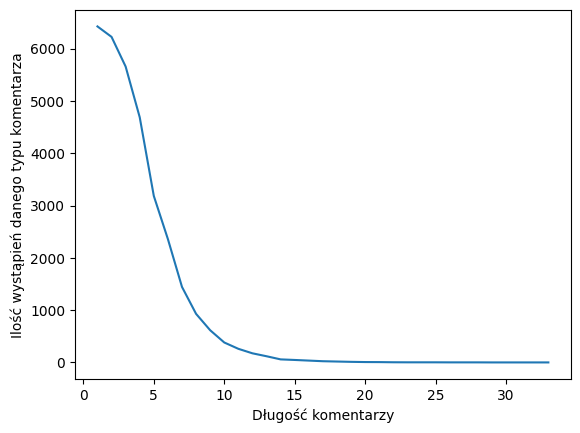

In [35]:
# Długość komentarzy
# Obliczenie z ilu wyrazów składają się komentarze
nowy_df['długość'] = nowy_df['tekst'].str.split().str.len()
counts = nowy_df['długość'].value_counts()

# Wykres
# Tworzenie osi X
x = range(1, len(counts) + 1)

# Tworzenie wykresu
plt.plot(x, counts)

# Konfiguracja etykiet osi
plt.xlabel('Długość komentarzy')
plt.ylabel('Ilość wystąpień danego typu komentarza')

# Wyświetlenie wykresu
plt.show()

### Analiza sentymentu


In [36]:
model = SentimentPLModel(from_pretrained='latest')

In [37]:
# Wykonanie analizy sentymentu na komentarzach
# Zakomentowana, gdyż długo trwa
# nowy_df['predykcja'] = nowy_df['tekst'].apply(lambda x: model(x).item())
# nowy_df

In [38]:
# Niestety wyniki są niesatysfakcjonujące

# Przykłady poniżej:
# "Brawo" - -0.17229433357715607
# "I to głowa państwa." - -0.00899549014866352
# "A niektózy nie szanują" - -0.4625290632247925
# "Inflacja" - 0.009782643988728523
# "Minuta wstydu" - 0.06330104917287827
# "Minuta prawdy" - -0.39027801156044006

#Przykład zastosowania
#print(model('Minuta prawdy').item())

### Najczęstsze słowa w komentarzach

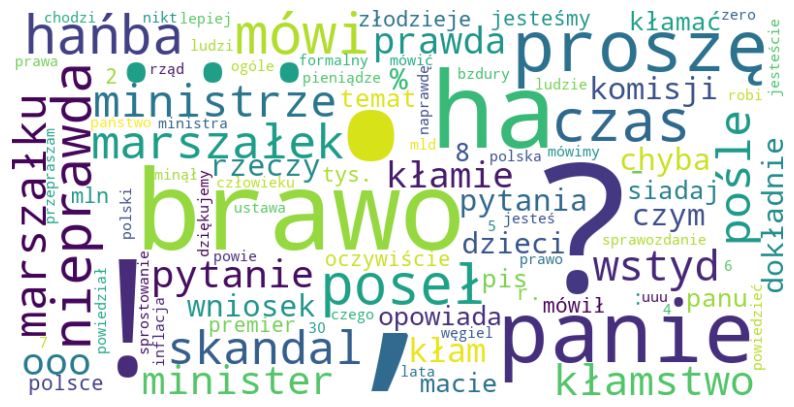

In [39]:
#Wordcloud z najczęściej pojawiającymi się słowami

# Pobranie listy polskich stop wordów
stop_words = json.loads(requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-pl/master/stopwords-pl.json").text)

# Konkatenacja tekstu ze wszystkich wierszy kolumny 'tekst'
all_text = ' '.join(nowy_df['tekst'])

# Tokenizacja tekstu na słowa
words = word_tokenize(all_text, language='polish')

# Zamiana tokenów na małe litery
words = [word.lower() for word in words]

# Filtrowanie stop wordów
filtered_words = [word for word in words if word.casefold() not in stop_words]

# Obliczenie liczności wystąpień słów
word_counts = Counter(filtered_words)

# Inicjalizacja obiektu WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Wyświetlenie wygenerowanego wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Zapisanie wordclouda
# plt.savefig('wordcloud.jpg', format='jpg', dpi=300)
plt.show()

In [77]:
# # Wypisanie najczęstszych słów
# sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
# for word, count in sorted_counts:
#     print(f'{word}: {count}')

sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
for i in range(20):
    word, count = sorted_counts[i]
    print(f'{word}: {count}')


.: 23234
,: 8734
?: 5647
!: 4680
...: 2604
brawo: 1938
ha: 1766
panie: 1098
proszę: 725
czas: 460
mówi: 435
poseł: 425
hańba: 401
nieprawda: 398
marszałek: 355
skandal: 347
pośle: 329
marszałku: 311
ministrze: 306
wstyd: 273


### Garść statystyk związanych z posłami

In [41]:
# Stworzenie kolumn zwiazanych z datą urodzenia oraz miejscem urodzenia
posłowie2[['data_urodzenia', 'miejsce_urodzenia']] = posłowie2['Data i miejsce urodzenia:'].str.split(',', 1, expand=True)

In [42]:
# Skąd pochodzą posłowie?
df_grouped = posłowie2.groupby('miejsce_urodzenia').size().reset_index(name='liczba')
df_miejsce_urodzenia = df_grouped.sort_values('liczba', ascending=False)
df_miejsce_urodzenia.head(10)

miejsce_urodzenia  liczba
204          Warszawa      41
81             Kraków      14
212           Wrocław      10
232              Łódź      10
38             Gdańsk       9
139            Poznań       9
187          Szczecin       7
39             Gdynia       7
67             Kielce       6
123             Opole       6

In [12]:
df_top5_miasta = df_miejsce_urodzenia.head(5)

# Wykres pokazujący skąd pochodzą posłowie
fig = px.bar(df_top5_miasta, x='miejsce_urodzenia', y='liczba')

fig.update_layout(title='Miejsce urodzenia')

fig.show()

In [44]:
# Wykształcenie posłów
df_grouped = posłowie2.groupby('Wykształcenie:').size().reset_index(name='liczba')
df_wykształcenie = df_grouped.sort_values('liczba', ascending=False)
df_wykształcenie

Wykształcenie:  liczba
0                          wyższe     427
1                  średnie ogólne      15
3                średnie zawodowe       9
2  średnie policealne/pomaturalne       7

In [13]:
fig = px.pie(df_wykształcenie, values='liczba', names='Wykształcenie:',
             title='Wykształcenie posłów')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

In [46]:
# Zawody posłów
połowie_zawod = posłowie2
połowie_zawod['Zawód:'] = połowie_zawod['Zawód:'].str.lower()

# Zmiana wartości kolumn, by móc zgrupować podobne zawody
połowie_zawod.loc[połowie_zawod['Zawód:'].str.contains('inżynier', case=False), 'Zawód:'] = 'inżynier'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('inż', case=False), 'Zawód:'] = 'inżynier'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('lekarz', case=False), 'Zawód:'] = 'lekarz'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('radca prawny', case=False), 'Zawód:'] = 'prawnik'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('adwokat', case=False), 'Zawód:'] = 'parlamentarzysta'

połowie_zawod.loc[posłowie2['Zawód:'].str.contains('poseł', case=False), 'Zawód:'] = 'parlamentarzysta'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('poseł na Sejm RP', case=False), 'Zawód:'] = 'parlamentarzysta'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('ekonomistka', case=False), 'Zawód:'] = 'ekonomista'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('samorząd', case=False), 'Zawód:'] = 'przedstawiciel władzy samorządowej'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('menadżer', case=False), 'Zawód:'] = 'menedżer'

połowie_zawod.loc[posłowie2['Zawód:'].str.contains('parlamentarzystka', case=False), 'Zawód:'] = 'parlamentarzysta'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('urzędnik', case=False), 'Zawód:'] = 'urzędnik'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('samorządowiec', case=False), 'Zawód:'] = 'przedstawiciel władzy samorządowej'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('notariusz', case=False), 'Zawód:'] = 'prawnik'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('prawniczka', case=False), 'Zawód:'] = 'prawnik'

połowie_zawod.loc[posłowie2['Zawód:'].str.contains('dziennikarka', case=False), 'Zawód:'] = 'dziennikarz'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('wykładowca akademicki', case=False), 'Zawód:'] = 'nauczyciel akademicki'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('profesor', case=False), 'Zawód:'] = 'nauczyciel akademicki'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('pracownik administracji', case=False), 'Zawód:'] = 'urzędnik'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('informaty', case=False), 'Zawód:'] = 'informatyk'

połowie_zawod.loc[posłowie2['Zawód:'].str.contains('programist', case=False), 'Zawód:'] = 'informatyk'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('nauczyciel akademicki', case=False), 'Zawód:'] = 'nauczyciel akademicki'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('filolo', case=False), 'Zawód:'] = 'filolog'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('nauczyciel historii', case=False), 'Zawód:'] = 'nauczyciel'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('nauczyciel wychowania fizycznego', case=False), 'Zawód:'] = 'nauczyciel'

połowie_zawod.loc[posłowie2['Zawód:'].str.contains('nauczycielka', case=False), 'Zawód:'] = 'nauczyciel'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('przedsiębiorca', case=False), 'Zawód:'] = 'przedsiębiorca'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('socjo', case=False), 'Zawód:'] = 'socjolog'
połowie_zawod.loc[posłowie2['Zawód:'].str.contains('rolnik', case=False), 'Zawód:'] = 'rolnik'

df_grouped = połowie_zawod.groupby('Zawód:').size().reset_index(name='liczba')
df_grouped_sorted = df_grouped.sort_values('liczba', ascending=False)

#Ciekawostka - jest tylk jedna filozofka (brak filozofów, choć trochę osób ukończyło wydział filozofii)
df_grouped_sorted.head(20)

Zawód:  liczba
42                    parlamentarzysta     107
48                             prawnik      43
17                          ekonomista      39
44                           politolog      27
26                            inżynier      21
41               nauczyciel akademicki      21
50                      przedsiębiorca      19
51  przedstawiciel władzy samorządowej      18
32                              lekarz      16
40                          nauczyciel      15
23                            historyk      14
70                            urzędnik      11
43                             pedagog       9
14                         dziennikarz       9
56                            socjolog       7
54                              rolnik       7
36                            menedżer       6
25                          informatyk       6
45                             polityk       4
20                             filolog       4

In [14]:
df_top5_zawody = df_grouped_sorted.head(5)

# Wykres zawodów wykonywanych przez posłów
fig = px.bar(df_top5_zawody, x='zawód', y='liczba')

fig.update_layout(title='Zawody')

fig.show()

### Przygotowanie danych do analizy przemów

In [48]:
def czy_posel(mowca):
    ###############################################################
    # Niniejsza funkcja określa, czy dane wystąpienie zostało     #
    # wygłoszone przez posła/posłankę. Wystąpienie może bowiem    #
    # być autorstwa ministrów, podsekretarzy stanu, itp.          #
    #                                                             #
    # Zwraca:                                                     #
    # 1 jeśli słowo "Poseł" występuje w polu "Mówca" (główna rola #
    # autora/autorki wystąpienia), zaś 0 w przeciwnym wypadku.    #
    #                                                             #
    # Parametry:                                                  #
    # mowca [string] -- zawartość pola "Mówca" ze strony Sejmu,   #
    # zawierającą informacje o autorze wystąpienia.               #
    ###############################################################

    if "Poseł" in mowca:
        wynik = 1
    else:
        wynik = 0

    return wynik

In [49]:
df_wypowiedzi["czy_posel"] = df_wypowiedzi["poseł"].apply(func=czy_posel)

In [50]:
df_wypowiedzi.drop(df_wypowiedzi[df_wypowiedzi["czy_posel"] == 0].index, inplace=True)

In [51]:
df_wypowiedzi["poseł"] = df_wypowiedzi["poseł"].apply(func=imie_nazwisko)

In [52]:
regex = r'\((.*?)\)'

#Oczyszczenie mowy z komentarzy
wypowiedzi['mowa'] = wypowiedzi['mowa'].str.replace(regex, '')

In [53]:
stop_words = json.loads(requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-pl/master/stopwords-pl.json").text)

In [54]:
def lematyzacja(mowa, stop_words=stop_words):
    ################################################################
    # Niniejsza funkcja przeprowadza normalizację oraz lematyzację #
    # tekstu:                                                      #
    #  * usuwane są znaki specjalne,                               #
    #  * wszystkie litery są zapisane jako małe,                   #
    #  * usuwane są tzw. stop words, czyli słowa, które nie wnoszą #
    #    dodatkowej informacji (np. spójniki).                     #
    # Następnie przeprowadzana jest lamatyzacja za pomocą pakietu  #
    # spaCy (moduł języka polskiego: pl_core_news_md).             #
    #                                                              #
    # Zwraca:                                                      #
    # listę słów zawartych w przemówieniu po zakończeniu procesu   #
    # normalizacji i lematyzacji.                                  #
    #                                                              #
    # Parametry:                                                   #
    # mowa [string] -- treść wystąpienia posła/posłanki.           #
    # stop_words [lista] -- lista zawierająca wszystkie słowa,     #
    # które mają być usunięte.                                     #
    ################################################################

    lista_slow = re.split("[-\s.,;!?]+", mowa)
    # lista_slow = [slowo.lower() for slowo in lista_slow]
    lista_slow = [slowo for slowo in lista_slow if slowo.lower() not in stop_words]

    # nlp = spacy.load('pl_core_news_md')
    # mowa_po_lematyzacji = [nlp(slowo) for slowo in lista_slow]
    # wynik = mowa_po_lematyzacji
    wynik = " ".join(lista_slow)

    return wynik

In [55]:
df_wypowiedzi["mowa"] = df_wypowiedzi["mowa"].apply(func=lematyzacja)

In [62]:
#df_wypowiedzi["mowa"]

## Analiza

### Ogólne statystyki

Sprawdźmy, który z parlamentarzystów najczęściej zabierał głos.

In [57]:
df_poslowie.head()

poseł     klub/koło  \
0      Mirosław Suchoń    Polska2050   
1        Jan Szopiński        Lewica   
2       Grzegorz Braun  Konfederacja   
3  Tadeusz Tomaszewski        Lewica   
4       Rafał Adamczyk        Lewica   

   Liczba wypowiedzi (W tym jako członka RM)  
0                                       1036  
1                                        970  
2                                        736  
3                                        519  
4                                        462

Zobaczmy także, kto udzielał się najmniej.

In [58]:
df_poslowie.tail()

poseł klub/koło  Liczba wypowiedzi (W tym jako członka RM)
462   Leonard Krasulski       PiS                                          1
463         Paweł Kukiz   Kukiz15                                          1
464   Aleksandra Łapiak       PiS                                          1
465       Marcin Ociepa       PiS                                          1
466  Dominik Tarczyński       PiS                                          1

Sprawdźmy, jak wyglądają zagregowane wyniki dla poszczególnych formacji politycznych.

In [59]:
wystapienia_per_capita = list(df_poslowie.groupby(["klub/koło"]).sum()["Liczba wypowiedzi (W tym jako członka RM)"] / df_poslowie.groupby(["klub/koło"]).count()["poseł"])
partie = list(np.sort(df_poslowie["klub/koło"].unique()))

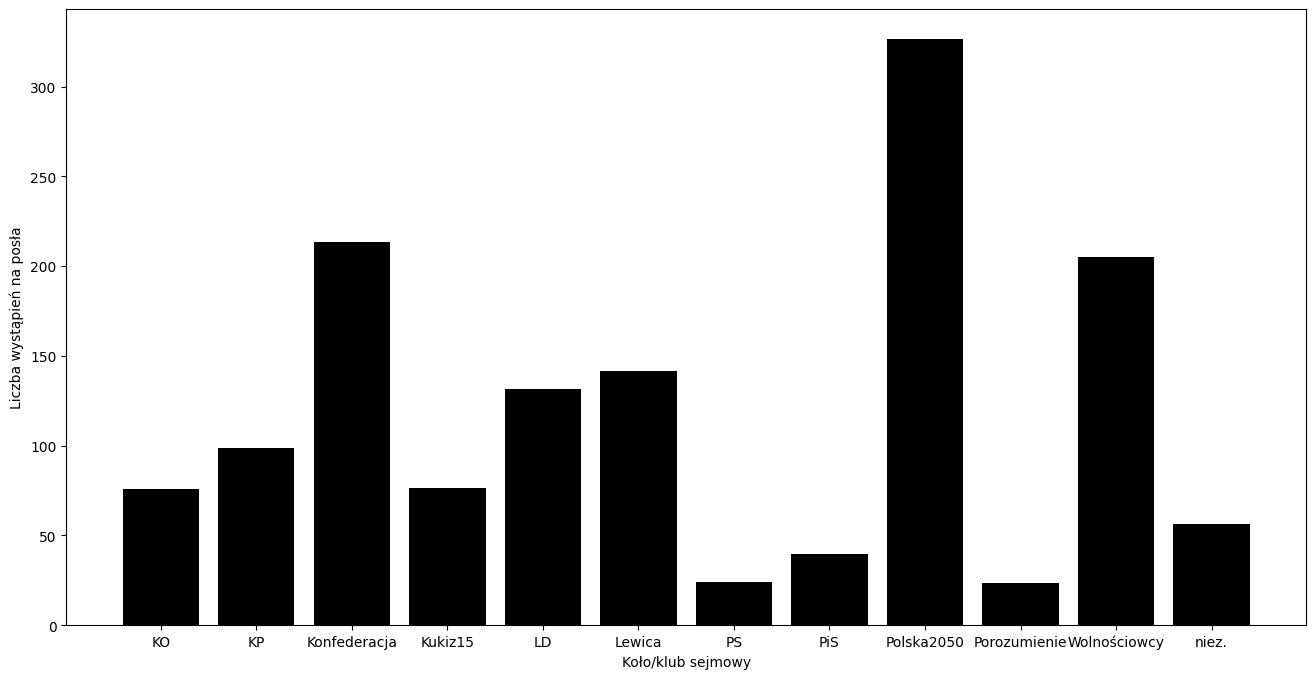

In [60]:
plt.figure(figsize=(16, 8))
plt.bar(partie, wystapienia_per_capita, color="black")
plt.xlabel("Koło/klub sejmowy")
plt.ylabel("Liczba wystąpień na posła")
# plt.savefig("wypowiedzi_partie.jpg")
plt.show()

### Modelowanie tematyczne

In [63]:
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)

#### Wszystkie wystąpienia

W pierwszej kolejności możemy dokonać analizy tematycznej zbioru złożonego ze wszystkich wystąpień posłów, które zostały dotychczas wygłoszone.

In [64]:
mowa_wszystkie = df_wypowiedzi["mowa"]
topics, probs = topic_model.fit_transform(mowa_wszystkie)

Batches: 100%|█████████████████████████████████████████████████████████████████████| 1022/1022 [56:33<00:00,  3.32s/it]
2023-07-30 14:50:53,878 - BERTopic - Transformed documents to Embeddings
2023-07-30 14:51:49,210 - BERTopic - Reduced dimensionality
2023-07-30 14:56:21,785 - BERTopic - Clustered reduced embeddings


In [65]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                            Name  \
0      -1  16070                 -1_panie_poseł_dziękuję_oklaski   
1       0    992           0_zdrowia_medycznych_lekarzy_szpitali   
2       1    600        1_emerytury_emerytów_emerytura_emeryturę   
3       2    565  2_mieszkań_mieszkania_mieszkanie_nieruchomości   
4       3    471                3_ukrainy_uchodźców_pomocy_pomoc   
5       4    459                4_pamięci_żołnierzy_św_powstania   
6       5    445                  5_rosji_putina_ukrainy_ukrainę   
7       6    332        6_telewizji_mediów_radiofonii_narodowych   
8       7    302         7_dyrektywy_europejskiej_przepisów_unii   
9       8    302               8_zwierząt_zwierzęta_hodowli_psów   
10      9    298              9_linii_kolejowych_kolejowej_kolei   
11     10    285      10_szczepień_szczepienia_szczepionek_covid   

                                       Representation  \
0   [panie, poseł, dziękuję, oklaski, państwo, sal...   
1   [zdrowia, medycznych, lekarzy, szpitali, pacje...   
2   [emerytury, emerytów, emerytura, emeryturę, em...   
3   [mieszkań, mieszkania, mieszkanie, nieruchomoś...   
4   [ukrainy, uchodźców, pomocy, pomoc, dzieci, uk...   
5   [pamięci, żołnierzy, św, powstania, armii, woj...   
6   [rosji, putina, ukrainy, ukrainę, ukrainie, ro...   
7   [telewizji, mediów, radiofonii, narodowych, ra...   
8   [dyrektywy, europejskiej, przepisów, unii, eur...   
9   [zwierząt, zwierzęta, hodowli, psów, gatunków,...   
10  [linii, kolejowych, kolejowej, kolei, kolejowe...   
11  [szczepień, szczepienia, szczepionek, covid, s...   

                                  Representative_Docs  
0   [Dziękuję Panie Marszałku Wysoka Izbo Panie Se...  
1   [Dziękuję panie marszałku Panie Marszałku Wyso...  
2   [Dziękuję Marszałek Wysoka Izbo Szanowny Panie...  
3   [Panie Marszałku Wysoka Izbo Minister imieniu ...  
4   [Szanowny Panie Marszałku Panie Ministrze Wyso...  
5   [Szanowny Panie Marszałku Wysoka Izbo 14 luteg...  
6   [Panie Marszałku Wysoki Sejmie Panie Panowie P...  
7   [Marszałek Wysoka Izbo Ochrona pluralizmu medi...  
8   [Marszałek Wysoka Izbo imieniu klubu Koalicji ...  
9   [Panie Marszałku Wysoka Izbo Panie Ministrze P...  
10  [dziękuję Szanowna Marszałek Panie Ministrze W...  
11  [Polsce ważniejszej sprawy szczepienia Polsce ...

In [66]:
topic_model.visualize_topics()

In [67]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig.write_html("tematy_wszystkie_wypowiedzi.html")

#### Wystąpienia poszczególnych partii

Wykonajmy teraz modelowanie tematyczne wystąpień poszczególnych klubów/kół poselskich. Ograniczmy się tylko do tych najważniejszych.

In [68]:
df_wypowiedzi

poseł                                               mowa  \
1          Daniel Milewski  (Sekretarz poseł odczytuje nazwiska posłów) Po...   
2         Mateusz Bochenek  Poseł Piotr Gliński: Ślubuję dopomóż Bóg Poseł...   
3          Daniel Milewski  Poseł Łukasz Szumowski: Ślubuję dopomóż Bóg Po...   
4         Mateusz Bochenek  Poseł Piotr Kaleta: Ślubuję dopomóż Bóg Poseł ...   
5          Daniel Milewski  Poseł Waldemar Buda: Ślubuję dopomóż Bóg Poseł...   
...                    ...                                                ...   
35701       Agnieszka Soin  Szanowna Marszałek Wysoka Izbo Spotykamy Dniu ...   
35702       Beata Strzałka  Uroczystości Szarajówce Marszałek Wysoka Izbo ...   
35703       Andrzej Szejna  Oświadczenie sprawie promocji honorowego krwio...   
35704        Jan Szopiński  Szanowna Marszałek Wysoka Izbo Panie Panowie P...   
35705  Tadeusz Tomaszewski  Szanowna Marszałek oświadczeniu poselskim chci...   

             data  posiedzenie  dzień_posiedzenia  numer_wypowiedzi  \
1      12-11-2019            1                  1                 2   
2      12-11-2019            1                  1                 3   
3      12-11-2019            1                  1                 4   
4      12-11-2019            1                  1                 5   
5      12-11-2019            1                  1                 6   
...           ...          ...                ...               ...   
35701  26-05-2023           76                  3               258   
35702  26-05-2023           76                  3               259   
35703  26-05-2023           76                  3               260   
35704  26-05-2023           76                  3               261   
35705  26-05-2023           76                  3               262   

       czy_wygloszony  czy_posel  
1                   0          1  
2                   0          1  
3                   0          1  
4                   0          1  
5                   0          1  
...               ...        ...  
35701               1          1  
35702               1          1  
35703               1          1  
35704               1          1  
35705               1          1  

[32691 rows x 8 columns]

In [69]:
df_poslowie

poseł     klub/koło  \
0        Mirosław Suchoń    Polska2050   
1          Jan Szopiński        Lewica   
2         Grzegorz Braun  Konfederacja   
3    Tadeusz Tomaszewski        Lewica   
4         Rafał Adamczyk        Lewica   
..                   ...           ...   
462    Leonard Krasulski           PiS   
463          Paweł Kukiz       Kukiz15   
464    Aleksandra Łapiak           PiS   
465        Marcin Ociepa           PiS   
466   Dominik Tarczyński           PiS   

     Liczba wypowiedzi (W tym jako członka RM)  
0                                         1036  
1                                          970  
2                                          736  
3                                          519  
4                                          462  
..                                         ...  
462                                          1  
463                                          1  
464                                          1  
465                                          1  
466                                          1  

[467 rows x 3 columns]

In [70]:
df_wypowiedzi_partii = pd.merge(df_wypowiedzi, df_poslowie, on="poseł", how="inner")

In [71]:
mowa_ko = df_wypowiedzi_partii.where(df_wypowiedzi_partii["klub/koło"]=="KO").dropna()["mowa"]
mowa_konf = df_wypowiedzi_partii.where(df_wypowiedzi_partii["klub/koło"]=="Konfederacja").dropna()["mowa"]
mowa_lew = df_wypowiedzi_partii.where(df_wypowiedzi_partii["klub/koło"]=="Lewica").dropna()["mowa"]
mowa_pis = df_wypowiedzi_partii.where(df_wypowiedzi_partii["klub/koło"]=="PiS").dropna()["mowa"]
mowa_pl = df_wypowiedzi_partii.where(df_wypowiedzi_partii["klub/koło"]=="Polska2050").dropna()["mowa"]

In [72]:
mowa_ko

57       Poseł Piotr Gliński: Ślubuję dopomóż Bóg Poseł...
58       Poseł Piotr Kaleta: Ślubuję dopomóż Bóg Poseł ...
59       Poseł Jan Warzecha: Ślubuję dopomóż Bóg Poseł ...
60       Poseł Wojciech Zubowski: Ślubuję dopomóż Bóg P...
61       Poseł Władysław Dajczak: Ślubuję dopomóż Bóg P...
                               ...                        
32618    Marszałek Wysoka Izbo imieniu Klubu Parlamenta...
32619    Marszałek Wysoka Izbo Szanowny Panie Ministrze...
32620    Panie Marszałku Wysoka Izbo imieniu Klubu Parl...
32621    Szanowna Marszałek Wysoka Izbo Szanowny Panie ...
32622    Panie Marszałku Minister Wysoka Izbo imieniu K...
Name: mowa, Length: 9966, dtype: object

* Koalicja Obywatelska

In [73]:
topics, probs = topic_model.fit_transform(mowa_ko)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 312/312 [18:29<00:00,  3.55s/it]
2023-07-30 15:15:19,326 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:15:37,435 - BERTopic - Reduced dimensionality
2023-07-30 15:15:48,753 - BERTopic - Clustered reduced embeddings


In [74]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                      Name  \
0      -1   4356           -1_panie_oklaski_poseł_dziękuję   
1       0    570     0_zdrowia_szpitali_lekarzy_medycznych   
2       1    274      1_rolników_rolnictwa_rolnicy_rolnych   
3       2    250          2_ukrainy_uchodźców_rosji_pomocy   
4       3    214  3_emerytów_emerytury_emerytura_emeryturę   
5       4    169       4_powstania_historii_pamięci_pamięć   
6       5    143  5_mieszkań_mieszkanie_mieszkania_program   
7       6    142                6_zero_gmina_pieniądze_mld   
8       7    127     7_nauczycieli_czarnek_edukacji_szkole   
9       8    126         8_kobiet_kobiety_aborcji_kobietom   
10      9    121         9_telewizji_radiofonii_mediów_tvp   
11     10    110             10_budżet_mld_budżetu_wydatki   

                                       Representation  \
0   [panie, oklaski, poseł, dziękuję, państwo, wys...   
1   [zdrowia, szpitali, lekarzy, medycznych, covid...   
2   [rolników, rolnictwa, rolnicy, rolnych, rolnik...   
3   [ukrainy, uchodźców, rosji, pomocy, putina, uk...   
4   [emerytów, emerytury, emerytura, emeryturę, em...   
5   [powstania, historii, pamięci, pamięć, rocznic...   
6   [mieszkań, mieszkanie, mieszkania, program, mł...   
7   [zero, gmina, pieniądze, mld, euro, inwestycji...   
8   [nauczycieli, czarnek, edukacji, szkole, szkoł...   
9   [kobiet, kobiety, aborcji, kobietom, ciąży, po...   
10  [telewizji, radiofonii, mediów, tvp, media, ra...   
11  [budżet, mld, budżetu, wydatki, wydatków, fina...   

                                  Representative_Docs  
0   [Panie Marszałku Wysoka Izbo 47 47 ludzi zobac...  
1   [Panie Marszałku Minister Wysoka Izbo Koalicja...  
2   [Szanowna Marszałek Panie Ministrze Szanowni P...  
3   [Panie Marszałku Panie Ministrze Wysoka Izbo J...  
4   [Dziękuję Marszałek Wysoka Izbo Szanowny Panie...  
5   [Marszałek Wysoka Izbo rzeczywiście niezwykle ...  
6   [Dziękuję Panie Marszałku Wysoka Izbo Panie Mi...  
7   [Dziękuję Marszałek Wysoka Izbo Śląsk ogromna ...  
8   [Szanowny Panie Marszałku Panie Panowie Posłow...  
9   [Panie Marszałku Minister Wysoka Izbo Aborcja ...  
10  [Panie Marszałku Panie Panowie Posłowie Rzeczy...  
11  [Dziękuję panie marszałku Właściwie równaniu (...

In [75]:
topic_model.visualize_topics()

In [76]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

* Konfederacja

In [78]:
topics, probs = topic_model.fit_transform(mowa_konf)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [03:37<00:00,  3.45s/it]
2023-07-30 15:20:37,934 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:20:46,454 - BERTopic - Reduced dimensionality
2023-07-30 15:20:46,731 - BERTopic - Clustered reduced embeddings


In [79]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                     Name  \
0      -1    823          -1_panie_państwo_poseł_dziękuję   
1       0    206     0_poseł_panie_wicemarszałek_grzegorz   
2       1    114          1_marszałek_sejmu_komisji_poseł   
3       2    110    2_rolników_rolnictwa_rolnicy_rolnikom   
4       3     77           3_podatki_podatek_vat_podatków   
5       4     64         4_europejskiej_umowy_unii_polski   
6       5     43           5_dzieci_dziecka_dziecko_życia   
7       6     43       6_covid_zdrowia_ludzi_koronawirusa   
8       7     40         7_budżet_pieniądze_mld_pieniędzy   
9       8     40     8_państwa_panie_państwo_ministerstwa   
10      9     37  9_energii_elektrowni_energetycznej_ceny   
11     10     36              10_poseł_sali_marszałek_kor   

                                       Representation  \
0   [panie, państwo, poseł, dziękuję, oklaski, dzw...   
1   [poseł, panie, wicemarszałek, grzegorz, braun,...   
2   [marszałek, sejmu, komisji, poseł, panie, wnio...   
3   [rolników, rolnictwa, rolnicy, rolnikom, panie...   
4   [podatki, podatek, vat, podatków, polaków, pod...   
5   [europejskiej, umowy, unii, polski, prawa, eur...   
6   [dzieci, dziecka, dziecko, życia, przestępstw,...   
7   [covid, zdrowia, ludzi, koronawirusa, rząd, zg...   
8   [budżet, pieniądze, mld, pieniędzy, państwa, p...   
9   [państwa, panie, państwo, ministerstwa, dzięku...   
10  [energii, elektrowni, energetycznej, ceny, prą...   
11  [poseł, sali, marszałek, kor, głos, państwo, p...   

                                  Representative_Docs  
0   [Panie Marszałku Panie Ministrze Wysoka Izbo R...  
1   [trybie sprostowania marszałek Wicemarszałek M...  
2   [Marszałek Wysoka Izbo Wczoraj odbyło ważne po...  
3   [Szanowny Panie Marszałku Wysoka Izbo Sytuacja...  
4   [Panie Marszałku Wysoka Izbo 8 rządów PiS lata...  
5   [Panie Marszałku Wysoka Izbo 30 lipca 2020 r z...  
6   [Panie Marszałku Wysoka Izbo Zawód lekarza zaw...  
7   [Marszałek Wysoka Izbo ustalmy czym mówimy eks...  
8   [Panie Marszałku Wysoka Izbo budżet budżet kry...  
9   [Szanowna Marszałek Wysoka Izbo Szanowny Panie...  
10  [Marszałek Wysoka Izbo Procedujemy ustawą doda...  
11  [Panie Marszałku Wysoka Izbo Kaczyński dymisji...

In [80]:
topic_model.visualize_topics()

In [81]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

* Lewica

In [82]:
topics, probs = topic_model.fit_transform(mowa_lew)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [11:18<00:00,  3.39s/it]
2023-07-30 15:32:09,730 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:32:22,446 - BERTopic - Reduced dimensionality
2023-07-30 15:32:25,753 - BERTopic - Clustered reduced embeddings


In [83]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                         Name  \
0      -1   2635              -1_panie_dziękuję_ustawy_wysoka   
1       0    508         0_zdrowia_covid_pacjentów_medycznych   
2       1    176       1_rolników_rolnictwa_rolnicy_produkcji   
3       2    175      2_emerytury_emerytów_emerytur_emeryturę   
4       3    144          3_odpadów_środowiska_wody_powietrza   
5       4    137  4_mieszkań_nieruchomości_mieszkania_wynajem   
6       5    122        5_nauczycieli_edukacji_szkoły_czarnek   
7       6    121               6_kobiet_kobiety_ciąży_aborcji   
8       7    105      7_linii_kolejowych_kolejowej_transportu   
9       8     97                8_mld_budżet_budżetu_budżecie   
10      9     79           9_mln_podatku_przedsiębiorców_rząd   
11     10     77          10_ruchu_drogach_drogowego_pojazdów   

                                       Representation  \
0   [panie, dziękuję, ustawy, wysoka, izbo, oklask...   
1   [zdrowia, covid, pacjentów, medycznych, szpita...   
2   [rolników, rolnictwa, rolnicy, produkcji, żywn...   
3   [emerytury, emerytów, emerytur, emeryturę, sen...   
4   [odpadów, środowiska, wody, powietrza, wód, śm...   
5   [mieszkań, nieruchomości, mieszkania, wynajem,...   
6   [nauczycieli, edukacji, szkoły, czarnek, naucz...   
7   [kobiet, kobiety, ciąży, aborcji, kobietom, ci...   
8   [linii, kolejowych, kolejowej, transportu, kol...   
9   [mld, budżet, budżetu, budżecie, pieniądze, zr...   
10  [mln, podatku, przedsiębiorców, rząd, podatków...   
11  [ruchu, drogach, drogowego, pojazdów, pieszych...   

                                  Representative_Docs  
0   [Marszałek Panie Ministrze Wysoka Izbo Rzeczyw...  
1   [Panie Marszałku Panie Ministrze Wysoka Izbo W...  
2   [Marszałek Panie Ministrze Wysoka Izbo zaszczy...  
3   [Panie Marszałku Wysoki Sejmie (Głos sali: ton...  
4   [Marszałek oświadczenie dotyczy apelu wystosow...  
5   [Szanowna Marszałek Panie Ministrze Wysoka Izb...  
6   [Marszałek Wysoka Izbo powiedziano ustawa znan...  
7   [Panie Marszałku Wysoka Izbo historię opowiedz...  
8   [Panie Marszałku Panie Ministrze Wysoka Izbo P...  
9   [Panie Marszałku Panie Ministrze Wysoka Izbo p...  
10  [Panie Marszałku Wysoka Izbo Prawdę mówiąc myś...  
11  [Dziękuję Panie Marszałku Wysoka Izbo Rządowy ...

In [84]:
topic_model.visualize_topics()

In [85]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig.write_html("tematy_lewica.html")

* Prawo i Sprawiedliwość

In [86]:
topics, probs = topic_model.fit_transform(mowa_pis)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 249/249 [15:07<00:00,  3.64s/it]
2023-07-30 15:47:41,261 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:47:54,655 - BERTopic - Reduced dimensionality
2023-07-30 15:48:01,740 - BERTopic - Clustered reduced embeddings


In [87]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                              Name  \
0      -1   3068                      -1_poseł_panie_dziękuję_sali   
1       0    194              0_zdrowia_medycznych_ochronę_lekarza   
2       1    158                             1_drogi_linii_dróg_km   
3       2    137             2_szczepień_covid_zdrowia_szczepienia   
4       3    135         3_ruchu_infrastruktury_drogowego_drogowym   
5       4    118           4_powstania_wojennego_żołnierzy_pamięci   
6       5    112  5_mieszkań_mieszkania_mieszkaniowych_budownictwa   
7       6    107                 6_rolnictwa_wsi_rozwoju_wiejskich   
8       7    103                        7_śmierci_ps_pamięci_armii   
9       8     95                             8_30_spraw_11_komisją   
10      9     95              9_społecznej_rodziny_polityki_ustawy   
11     10     91       10_inwestycji_mln_inwestycje_strategicznych   

                                       Representation  \
0   [poseł, panie, dziękuję, sali, państwo, ustawy...   
1   [zdrowia, medycznych, ochronę, lekarza, lekarz...   
2   [drogi, linii, dróg, km, inwestycji, obwodnic,...   
3   [szczepień, covid, zdrowia, szczepienia, 19, z...   
4   [ruchu, infrastruktury, drogowego, drogowym, p...   
5   [powstania, wojennego, żołnierzy, pamięci, gru...   
6   [mieszkań, mieszkania, mieszkaniowych, budowni...   
7   [rolnictwa, wsi, rozwoju, wiejskich, ustawy, r...   
8   [śmierci, ps, pamięci, armii, ks, krajowej, po...   
9   [30, spraw, 11, komisją, zespołu, odbędą, 10, ...   
10  [społecznej, rodziny, polityki, ustawy, komisj...   
11  [inwestycji, mln, inwestycje, strategicznych, ...   

                                  Representative_Docs  
0   [dziękuję Marszałek Wysoka Izbo Szanowni Państ...  
1   [Marszałek Wysoka Izbo ramach ustawy budżetowe...  
2   [Marszałek Wysoka Izbo 29 listopada 2021 r zos...  
3   [Dziękuję Panie Marszałku Panie Ministrze Wyso...  
4   [Marszałek Panie Ministrze Wysoki Sejmie zaszc...  
5   [Oświadczenie poselskie 25 stycznia 2023 r spr...  
6   [Dziękuję Wysoka Izbo Poprawa dostępności mies...  
7   [Panie Marszałku Wysoka Izbo Przypadł udziale ...  
8   [Panie Marszałku Wysoki Sejmie Pragnę wygłosić...  
9   [Marszałek Wysoka Izbo Pragnę poinformować dni...  
10  [Marszałek Wysoka Izbo Przedstawiam dodatkowe ...  
11  [Marszałek Wysoka Izbo ostatnim czasie premier...

In [88]:
topic_model.visualize_topics()

In [89]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

* Polska 2050

In [90]:
topics, probs = topic_model.fit_transform(mowa_pl)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 64/64 [03:32<00:00,  3.32s/it]
2023-07-30 15:51:43,466 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:51:51,950 - BERTopic - Reduced dimensionality
2023-07-30 15:51:52,257 - BERTopic - Clustered reduced embeddings


In [91]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                        Name  \
0      -1    884          -1_panie_dziękuję_ministrze_wysoka   
1       0    135                  0_energii_węgla_ceny_panie   
2       1     83              1_uchwały_dziękuję_wysoka_izbo   
3       2     75               2_ustawy_projektu_2050_polska   
4       3     66          3_zdrowia_panie_pacjentów_szpitali   
5       4     64           4_unii_europejskiej_polski_polska   
6       5     61            5_dziękuję_panie_ministrze_ruchu   
7       6     56        6_rolników_rolnictwa_ustawy_dziękuję   
8       7     44  7_danych_cyfryzacji_państwo_elektronicznej   
9       8     42       8_ukrainie_poseł_rosyjskich_marszałek   
10      9     39             9_panie_mld_pieniądze_premierze   
11     10     34            10_dzieci_przemocy_języka_kobiet   

                                       Representation  \
0   [panie, dziękuję, ministrze, wysoka, izbo, okl...   
1   [energii, węgla, ceny, panie, gazu, rząd, pose...   
2   [uchwały, dziękuję, wysoka, izbo, śląskiego, m...   
3   [ustawy, projektu, 2050, polska, podatku, parl...   
4   [zdrowia, panie, pacjentów, szpitali, ministrz...   
5   [unii, europejskiej, polski, polska, europejsk...   
6   [dziękuję, panie, ministrze, ruchu, ministerst...   
7   [rolników, rolnictwa, ustawy, dziękuję, projek...   
8   [danych, cyfryzacji, państwo, elektronicznej, ...   
9   [ukrainie, poseł, rosyjskich, marszałek, ukrai...   
10  [panie, mld, pieniądze, premierze, oklaski, fi...   
11  [dzieci, przemocy, języka, kobiet, polsce, kob...   

                                  Representative_Docs  
0   [Szanowny Panie Marszałku Panie Ministrze Wyso...  
1   [Serdecznie pozdrowienia seniorów Konina Panie...  
2   [Szanowny Panie Marszałku Wysoka Izbo 14 luteg...  
3   [Uprzejmie dziękuję Szanowna Marszałek Wysoka ...  
4   [dziękuję Szanowna Marszałek Panie Ministrze W...  
5   [Marszałek Wysoka Izbo imieniu Klubu Parlament...  
6   [dziękuję Panie Marszałku Panie Ministrze Wyso...  
7   [dziękuję Szanowna Marszałek Panie Ministrze W...  
8   [Szanowna Minister Panie Marszałku Wysoka Izbo...  
9   [Panie Marszałku Panie Ministrze Panie Panowie...  
10  [Marszałek Panie Panowie Posłowie Panie Minist...  
11  [Szanowna Marszałek Wysoka Izbo głosowania bud...

In [92]:
topic_model.visualize_topics()

In [93]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

#### Wystąpienia z poszczególnych posiedzeń

Spójrzmy jeszcze, co znajdziemy, gdy analizie poddamy poszczególne posiedzenia Sejmu RP.

* Posiedzenie odbyte w dniach 27-28 października 2020 roku.

In [94]:
mowa_pos_20 = df_wypowiedzi.where(df_wypowiedzi["posiedzenie"]==20).dropna()["mowa"]

In [95]:
topics, probs = topic_model.fit_transform(mowa_pos_20)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.19s/it]
2023-07-30 15:52:27,243 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:52:30,984 - BERTopic - Reduced dimensionality
2023-07-30 15:52:31,035 - BERTopic - Clustered reduced embeddings


In [96]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                               Name  \
0     -1     52      -1_dziękuję_ustawy_panie_izbo   
1      0    142          0_poseł_panie_ustawy_sali   
2      1     55       1_kobiet_poseł_kobiety_prawa   
3      2     42         2_cit_spółki_spółek_polsce   
4      3     15  3_mieszkań_mieszkanie_program_kzn   
5      4     11     4_kontroli_izby_najwyższej_nik   

                                      Representation  \
0  [dziękuję, ustawy, panie, izbo, wysoka, marsza...   
1  [poseł, panie, ustawy, sali, oklaski, dziękuję...   
2  [kobiet, poseł, kobiety, prawa, ciąży, oklaski...   
3  [cit, spółki, spółek, polsce, przedsiębiorców,...   
4  [mieszkań, mieszkanie, program, kzn, wysoka, i...   
5  [kontroli, izby, najwyższej, nik, prezesa, 201...   

                                 Representative_Docs  
0  [Marszałek Wysoka Izbo imieniu klubu Lewicy za...  
1  [Panie Marszałku pierwsze czas leci doszłam ro...  
2  [Panie Marszałku Wysoka Izbo Panie Prezesie Ka...  
3  [Dziękuję Szanowna Marszałek Wysoka Izbo Cieka...  
4  [Szanowny Panie Marszałku Wysoka Izbo zaszczyt...  
5  [Marszałek Wysoka Izbo Szanowni Państwo Rozmaw...

In [97]:
topic_model.visualize_topics()

In [98]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig.write_html("wypowiedzi_aborcja.html")

* Posiedzenie odbyte w danich 23-24 lutego oraz 3 marca 2022 roku.

In [99]:
mowa_pos_49 = df_wypowiedzi.where(df_wypowiedzi["posiedzenie"]==49).dropna()["mowa"]

In [100]:
topics, probs = topic_model.fit_transform(mowa_pos_49)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.07s/it]
2023-07-30 15:53:12,947 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:53:16,469 - BERTopic - Reduced dimensionality
2023-07-30 15:53:16,543 - BERTopic - Clustered reduced embeddings


In [101]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                                          Name  \
0      -1     77               -1_panie_dziękuję_oklaski_poseł   
1       0     59               0_oklaski_ukrainy_panie_ukrainę   
2       1     51            1_transportu_dziękuję_panie_ustawy   
3       2     40         2_publicznej_ustawy_przestrzeni_nazwy   
4       3     32           3_agencji_rolnictwa_spółki_rolników   
5       4     30              4_ustawy_europejskiej_unii_panie   
6       5     26  5_ppe_emerytalnych_pracodawców_pracowniczych   
7       6     23                      6_gazu_gaz_sieci_projekt   
8       7     21        7_ustawy_bezpieczeństwa_państwa_ustawa   
9       8     17                    8_podatku_podatek_panie_30   
10      9     16                9_oklaski_panie_ministrze_ładu   
11     10     12                  10_sprzęt_polski_broni_panie   

                                       Representation  \
0   [panie, dziękuję, oklaski, poseł, ministrze, p...   
1   [oklaski, ukrainy, panie, ukrainę, wojna, musi...   
2   [transportu, dziękuję, panie, ustawy, transpor...   
3   [publicznej, ustawy, przestrzeni, nazwy, ustaw...   
4   [agencji, rolnictwa, spółki, rolników, restruk...   
5   [ustawy, europejskiej, unii, panie, projekt, e...   
6   [ppe, emerytalnych, pracodawców, pracowniczych...   
7   [gazu, gaz, sieci, projekt, dziękuję, ministrz...   
8   [ustawy, bezpieczeństwa, państwa, ustawa, stra...   
9   [podatku, podatek, panie, 30, ministrze, zdrow...   
10  [oklaski, panie, ministrze, ładu, głos, sali, ...   
11  [sprzęt, polski, broni, panie, obrony, zdolnoś...   

                                  Representative_Docs  
0   [Panie Marszałku Wysoki Sejmie Szanowni Przeds...  
1   [Dziękuję Panie Marszałku Panie Ministrze Wyso...  
2   [Marszałek Wysoka Izbo Dnia 1 lutego Rada Mini...  
3   [Szanowna Marszałek Panie Panowie Posłowie imi...  
4   [Szanowna Marszałek Panie Ministrze Wysoka Izb...  
5   [dziękuję Panie Marszałku Panie Ministrze Wyso...  
6   [Marszałek Wysoki Sejmie Przedkładam sprawozda...  
7   [Dziękuję Marszałek Wysoka Izbo Rozmawiamy prz...  
8   [uprzejmie dziękuję Szanowna Marszałek Wysoka ...  
9   [Panie Marszałku Wysoka Izbo Polski Ład będzie...  
10  [Marszałek Panie Ministrze Wysoka Izbo Poseł P...  
11  [Panie Marszałku Wysoka Izbo miesięcy ministro...

In [102]:
topic_model.visualize_topics()

In [103]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

#### Wystąpienia poszczególnych posłów

Zobaczmy także, czy możemy dokonać analizy wypowiedzi poszczególnych parlamentarzystów. Dla przykładu weźmy kontrowersyjnego posła Grzegorz Brauna (Konfederacja).

In [104]:
mowa_braun = df_wypowiedzi_partii.where(df_wypowiedzi_partii["poseł"]=="Grzegorz Braun").dropna()["mowa"]

In [105]:
topics, probs = topic_model.fit_transform(mowa_braun)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [01:17<00:00,  3.11s/it]
2023-07-30 15:54:36,683 - BERTopic - Transformed documents to Embeddings
2023-07-30 15:54:41,292 - BERTopic - Reduced dimensionality
2023-07-30 15:54:41,403 - BERTopic - Clustered reduced embeddings


In [106]:
freq = topic_model.get_topic_info(); freq.head(12)

Topic  Count                              Name  \
0      -1    387    -1_panie_poseł_dzwonek_państwo   
1       0     84     0_marszałek_panie_poseł_sejmu   
2       1     58   1_panie_dzwonek_poseł_ministrze   
3       2     43    2_wobec_dzwonek_panie_wolności   
4       3     42          3_poseł_panie_braun_głos   
5       4     33         4_rolno_wsi_boże_rolnikom   
6       5     27    5_pytanie_proszę_dzwonek_poseł   
7       6     25      6_panie_państwo_szczęść_boże   
8       7     24      7_szczęść_boże_państwo_panie   
9       8     17        8_zgonów_ludzi_poseł_życie   
10      9     16  9_polskiej_nauki_polski_historię   
11     10     15    10_prawa_dzwonek_panie_państwo   

                                       Representation  \
0   [panie, poseł, dzwonek, państwo, wicemarszałek...   
1   [marszałek, panie, poseł, sejmu, wniosek, pros...   
2   [panie, dzwonek, poseł, ministrze, państwo, py...   
3   [wobec, dzwonek, panie, wolności, ministrze, d...   
4   [poseł, panie, braun, głos, grzegorz, sali, wi...   
5   [rolno, wsi, boże, rolnikom, polskiego, szczęś...   
6   [pytanie, proszę, dzwonek, poseł, panie, pieni...   
7   [panie, państwo, szczęść, boże, poseł, dzwonek...   
8   [szczęść, boże, państwo, panie, polski, obywat...   
9   [zgonów, ludzi, poseł, życie, nadmiarowych, pa...   
10  [polskiej, nauki, polski, historię, dzwonek, d...   
11  [prawa, dzwonek, panie, państwo, system, teryt...   

                                  Representative_Docs  
0   [Szczęść Boże Wysoka pustawa Izbo Koledzy Drod...  
1   [Szczęść Boże Marszałek Wysoka Izbo Rozumiem k...  
2   [Panie Marszałku Wysoka Izbo ciekawy miewa spr...  
3   [zostało poprzednich mówców archiwum marszałek...  
4   [trybie sprostowania marszałek Wicemarszałek M...  
5   [Szczęść Boże wsi polskiej ratuj Zjednoczona ł...  
6   [Szczęść Boże ratuj Szanowna Marszałek budżet ...  
7   [Szczęść Boże osobom obarczonym różnymi deficy...  
8   [Szczęść Boże rodakom mieszkańcom Polski obarc...  
9   [Szczęść Boże Ratuj Zjednoczona łże Prawica śc...  
10  [Szczęść Boże Panie Marszałku Opustoszała Wyso...  
11  [Szczęść Boże Ratuj Zjednoczona łże Prawica im...

In [107]:
topic_model.visualize_topics()

In [108]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10)
# fig.write_html("tematy_braun.html")